# Exoplanet Ranking
Data discovering, preprocessing, computing simillarity and clustering.

**!! What is actually an exoplanet?**

## 1. Data Discovering
> To detect the important data it's necessary to go through the dataset and check what the columns stand for, which are useful for further processing, what the columns stand for. In this stage we will also fill information about the Earth (planet with rowid 0), since actual data is "random".

> Some data has been already removed in the very first processing (e.g. links, duplicated values, irrelevant data). Original dataset: `data/data_original.csv`

In [26]:
# imports
#%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [2]:
# loading data
df_origin = pd.read_csv("../data/data_preprocess.csv", index_col="rowid")
print("Number of:\n\trows = {}\n\tcolumns = {}".format(df_origin.shape[0], df_origin.shape[1]))
display(df_origin.head())
display(df_origin.info())

Number of:
	rows = 4056
	columns = 22


,fpl_orbper,fpl_smax,fpl_eccen,fpl_bmasse,fpl_rade,fpl_dens,fpl_tranflag,fpl_cbflag,fpl_snum,dec,...,fst_spt,fst_teff,fst_logg,fst_lum,fst_mass,fst_rad,fst_met,fst_metratio,fst_age,simil
rowid,,,,,,,,,,,,,,,,,,,,,
0,1000.00000,3.00,0.300,1000.0000,12.4,10.00,0,0,1,30.000000,...,K0 III,4742.0,3.00,1.000,1.50,7.00,-0.01,[Fe/H],0.400000,84.0188
1,326.03000,1.29,0.231,6165.6000,12.1,19.10,0,0,1,17.792868,...,K0 III,4742.0,2.31,2.243,2.70,19.00,-0.35,[Fe/H],4.236718,39.4383
2,516.21997,1.53,0.080,4684.8142,12.3,13.80,0,0,1,71.823898,...,K4 III,4213.0,1.93,2.430,2.78,29.79,-0.02,[Fe/H],1.560000,78.3099
3,185.84000,0.83,0.000,1525.5000,12.9,3.90,0,0,1,39.236198,...,G8 III,4813.0,2.63,1.763,2.20,11.00,-0.24,[Fe/H],4.500000,79.8440
4,1773.40002,2.93,0.370,1481.0878,12.9,3.79,0,0,1,43.817646,...,K0 V,5338.0,4.45,-0.151,0.90,0.93,0.41,[Fe/H],5.240000,91.1647


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4056 entries, 0 to 4055
Data columns (total 22 columns):
fpl_orbper      4056 non-null float64
fpl_smax        4056 non-null float64
fpl_eccen       1553 non-null float64
fpl_bmasse      4056 non-null float64
fpl_rade        4056 non-null float64
fpl_dens        4056 non-null float64
fpl_tranflag    4056 non-null int64
fpl_cbflag      4056 non-null int64
fpl_snum        4056 non-null int64
dec             4056 non-null float64
fst_optmag      4056 non-null float64
fst_nirmag      4056 non-null float64
fst_spt         1366 non-null object
fst_teff        4056 non-null float64
fst_logg        4056 non-null float64
fst_lum         4056 non-null float64
fst_mass        4056 non-null float64
fst_rad         4056 non-null float64
fst_met         4056 non-null float64
fst_metratio    4056 non-null object
fst_age         4056 non-null float64
simil           4056 non-null float64
dtypes: float64(17), int64(3), object(2)
memory usage: 728.8+ KB


None

### 1.1 Missing values

In [3]:
# number of missing values in each column
display(df_origin.notnull().sum() / (df_origin.notnull().sum() + df_origin.isnull().sum()))

fpl_orbper      1.000000
fpl_smax        1.000000
fpl_eccen       0.382890
fpl_bmasse      1.000000
fpl_rade        1.000000
fpl_dens        1.000000
fpl_tranflag    1.000000
fpl_cbflag      1.000000
fpl_snum        1.000000
dec             1.000000
fst_optmag      1.000000
fst_nirmag      1.000000
fst_spt         0.336785
fst_teff        1.000000
fst_logg        1.000000
fst_lum         1.000000
fst_mass        1.000000
fst_rad         1.000000
fst_met         1.000000
fst_metratio    1.000000
fst_age         1.000000
simil           1.000000
dtype: float64

> The most of the values are fully filled, but there are two columns with missing values: column `fpl_eccen` and column `fst_spt`. `fpl_eccen` holds  the eccentricity of planet's orbit (Amount by which the orbit of the planet deviates from a perfect circle). `fst_spt` holds spectral type of the star that the planet orbits.
> Since there is only 33 % -- 38 %  valid values, it is better to remove these columns then trying to compute the value using for example k-nn.

In [4]:
df_modified = df_origin.drop(labels=["fpl_eccen", "fst_spt"], axis=1)
print(df_modified.columns)

Index(['fpl_orbper', 'fpl_smax', 'fpl_bmasse', 'fpl_rade', 'fpl_dens',
       'fpl_tranflag', 'fpl_cbflag', 'fpl_snum', 'dec', 'fst_optmag',
       'fst_nirmag', 'fst_teff', 'fst_logg', 'fst_lum', 'fst_mass', 'fst_rad',
       'fst_met', 'fst_metratio', 'fst_age', 'simil'],
      dtype='object')


### 1.2 Non-numeric values
> There is a column `fst_metratio` containing information about which element is in abundance on the planet. The column contains data type `object`.


In [5]:
df_modified["fst_metratio"].unique()

array(['[Fe/H]', '[M/H]', '[m/H]'], dtype=object)

> `Fe/H` denotes iron abundance and `M/H` or `m/H` denotes general metal content.

In [6]:
# replacing all occurancies of "m/H" with "M/H" and then replacing with 

df_modified.loc[df_modified["fst_metratio"] == "[m/H]", "fst_metratio"] = "[M/H]"
df_modified["fst_metratio"] = df_modified["fst_metratio"].astype("category")
cat_columns = df_modified.select_dtypes("category").columns
cont_cols = list(df_modified.select_dtypes(exclude="category").columns) # columns with continuous values
dis_cols = list(cat_columns) # cols with discrete values
df_modified[cat_columns] = df_modified[cat_columns].apply(lambda x: x.cat.codes)

df_modified["fst_metratio"].unique()

array([0, 1])

## 1.3 Earth Filling-in

In [7]:
def dropColumn(elem, lists):
    for l in lists:
        if(elem in l):
            l.remove(elem)

In [8]:
display(df_modified.describe())

df_modified.loc[0, "fpl_orbper"] = 365.256363 # orbital period in days
df_modified.loc[0, "fpl_smax"] = 1.000001018 # the longest radius of an elliptic orbit
df_modified.loc[0, "fpl_bmasse"] = 1 # mass of the planet (earth unit)
df_modified.loc[0, "fpl_rade"] = 1 # radius (earth unit)
df_modified.loc[0, "fpl_dens"] = 5.51 # density of the planet (g/cm**3)
df_modified.loc[0, "fpl_tranflag"] = 1 # does planet transit the star
df_modified.loc[0, "fpl_cbflag"] = 0 # does planet orbit a binary solar system
df_modified.loc[0, "fpl_snum"] = 1 # number of stars in the solar system
df_modified.loc[0, "dec"] = 23.4 # declination of the planetary system
df_modified.drop(labels=["fst_optmag"], axis=1, inplace=True) # optical magnitude
dropColumn("fst_optmag", [cont_cols, dis_cols])
df_modified.drop(labels=["fst_nirmag"], axis=1, inplace=True) # near-IR magnitude
dropColumn("fst_nirmag", [cont_cols, dis_cols])
df_modified.loc[0, "fst_teff"] = 252 # effective temperature in Kelvins
df_modified.loc[0, "fst_logg"] = 5.437751 # gravity acceleration at the star surface log10(cm/s**2)
df_modified.loc[0, "fst_lum"] = 0 # star lumonisty log10(lumonisity)
df_modified.loc[0, "fst_mass"] = 1 # stellar mass (sun unit)
df_modified.loc[0, "fst_rad"] = 1 # stellar raidus (sun unit)
df_modified.loc[0, "fst_met"] = 0.012 # star metallicity
df_modified.loc[0, "fst_metratio"] = 0 # metal abundance (in comparison to sun)
df_modified.loc[0, "fst_age"] = 4.603 # stellar age (in billions)
df_modified.drop(labels=["simil"], axis=1, inplace=True) # random similarity (for visualizing purposes)
dropColumn("simil", [cont_cols, dis_cols])

display(df_modified.head())
print("cols with continuous values:", cont_cols)
print("cols with discrete values:", dis_cols)

,fpl_orbper,fpl_smax,fpl_bmasse,fpl_rade,fpl_dens,fpl_tranflag,fpl_cbflag,fpl_snum,dec,fst_optmag,fst_nirmag,fst_teff,fst_logg,fst_lum,fst_mass,fst_rad,fst_met,fst_metratio,fst_age,simil
count,4.056000e+03,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000
mean,2.319214e+03,6.175326,482.639263,5.640240,4.382642,0.774655,0.007396,1.039448,23.462613,12.692710,10.749454,5488.028300,4.354505,-0.074887,0.995157,1.542292,0.011103,0.020710,4.235773,50.071795
std,1.149917e+05,61.722017,4310.965809,5.411817,23.520291,0.417861,0.085695,0.221912,32.475112,2.917488,2.941231,1728.947747,0.409865,0.702312,0.593272,3.604334,0.163034,0.142429,2.016376,28.881371
min,9.070629e-02,0.004400,0.020000,0.336000,0.030000,0.000000,0.000000,1.000000,-84.231613,0.850000,-3.044000,575.000000,1.200000,-6.090000,0.010000,0.010000,-0.890000,0.000000,0.001000,0.004688
25%,4.610251e+00,0.080000,3.780000,1.729250,1.460000,1.000000,0.000000,1.000000,0.968397,11.579500,9.558250,5027.000000,4.300000,-0.412000,0.820000,0.800000,-0.060000,0.000000,3.200000,24.762150
50%,1.261125e+01,0.956900,8.200000,2.690000,2.680000,1.000000,0.000000,1.000000,40.919329,13.545500,11.722500,5570.000000,4.430000,-0.072000,0.960000,0.990000,0.011108,0.000000,4.236718,50.807200
75%,5.079753e+01,6.176109,177.984800,11.785750,4.562500,1.000000,0.000000,1.000000,45.866345,14.874000,12.931250,5911.000000,4.550000,0.316000,1.110000,1.300000,0.090000,0.000000,4.680000,74.973200
max,7.300000e+06,2500.000000,239000.000000,77.342000,1290.000000,1.000000,1.000000,4.000000,85.736153,20.480000,16.612000,57000.000000,5.520000,3.540000,23.560000,71.230000,0.690000,1.000000,14.900000,99.999400


,fpl_orbper,fpl_smax,fpl_bmasse,fpl_rade,fpl_dens,fpl_tranflag,fpl_cbflag,fpl_snum,dec,fst_teff,fst_logg,fst_lum,fst_mass,fst_rad,fst_met,fst_metratio,fst_age
rowid,,,,,,,,,,,,,,,,,
0,365.256363,1.000001,1.0000,1.0,5.51,1,0,1,23.400000,252.0,5.437751,0.000,1.00,1.00,0.012,0,4.603000
1,326.030000,1.290000,6165.6000,12.1,19.10,0,0,1,17.792868,4742.0,2.310000,2.243,2.70,19.00,-0.350,0,4.236718
2,516.219970,1.530000,4684.8142,12.3,13.80,0,0,1,71.823898,4213.0,1.930000,2.430,2.78,29.79,-0.020,0,1.560000
3,185.840000,0.830000,1525.5000,12.9,3.90,0,0,1,39.236198,4813.0,2.630000,1.763,2.20,11.00,-0.240,0,4.500000
4,1773.400020,2.930000,1481.0878,12.9,3.79,0,0,1,43.817646,5338.0,4.450000,-0.151,0.90,0.93,0.410,0,5.240000


cols with continuous values: ['fpl_orbper', 'fpl_smax', 'fpl_bmasse', 'fpl_rade', 'fpl_dens', 'fpl_tranflag', 'fpl_cbflag', 'fpl_snum', 'dec', 'fst_teff', 'fst_logg', 'fst_lum', 'fst_mass', 'fst_rad', 'fst_met', 'fst_age']
cols with discrete values: ['fst_metratio']


## 2. General Data Analysis
> Analysing the data: 
* mean and deviation
* distribution
* joint distribution,
* ... 

In [9]:
df_vis = df_modified.copy()
# cont_cols -- continuous columns
# dis_cols -- discrete columns

### 2.1 Mean, Deviation and Ratio

/Users/tottop/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


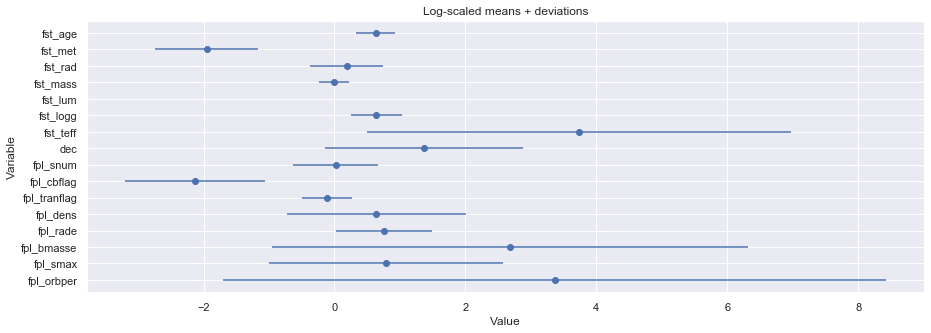

In [10]:
# log-scaled mean of the each variable with its standard deviation (sqrt from variance)

mean_log = np.log10(df_vis[cont_cols].mean())
std_log = np.log10(df_vis[cont_cols].std())
y_vals = np.arange(len(mean_log))

fix, ax = plt.subplots(figsize=(15,5))
ax.errorbar(mean_log, y_vals, xerr=std_log, ls='none', fmt='o')
ax.set_xlabel("Value")
ax.set_ylabel("Variable")
ax.set_yticks(y_vals)
ax.set_yticklabels(cont_cols)
ax.set_title("Log-scaled means + deviations")
plt.show()

> As visible from the figure above, the stellar mass (fst_mass) is pretty constant across all the data. On the other hand orbital period varies from $ 10^{-2} $ to $ 10^8 $. All the values are log-scaled so it can be easily compared.

In fst_metration (metal abundance): 
	0 = iron abundance, 
	1 = general metal abundance


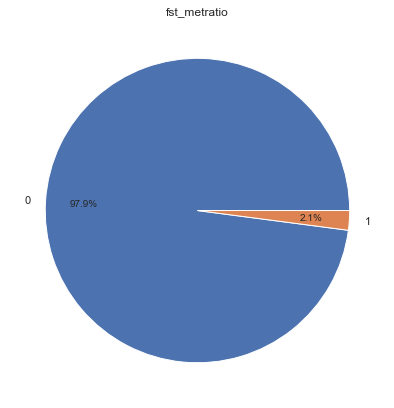

In [11]:
for col in dis_cols:
    val_count = df_vis[col].notnull().count()
    labels = []
    counts = []
    for val in df_vis[col].unique():
        labels.append(val)
        #counts.append(df_vis[df_vis[col] == val][col].count() / val_count)
        counts.append(df_vis[df_vis[col] == val][col].count())
    fix, ax = plt.subplots(figsize=(7,7))
    ax.pie(counts, labels=labels, autopct='%1.1f%%', pctdistance=0.75, radius=1)
    ax.set_title(col)
    
print("In fst_metration (metal abundance): \n\t0 = iron abundance, \n\t1 = general metal abundance")

> Perhaps it's not even necessary to emphasize that at the most of the exoplanets there is a iron abundance...

### 2.2 Density of Random Variable
> Since there is 16 random variables (${16\choose2} = 120$), only a few of those that are interesting haven been chosen to display the graph.

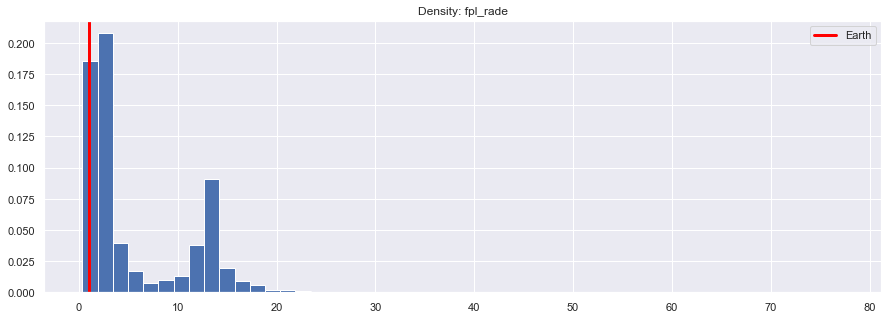

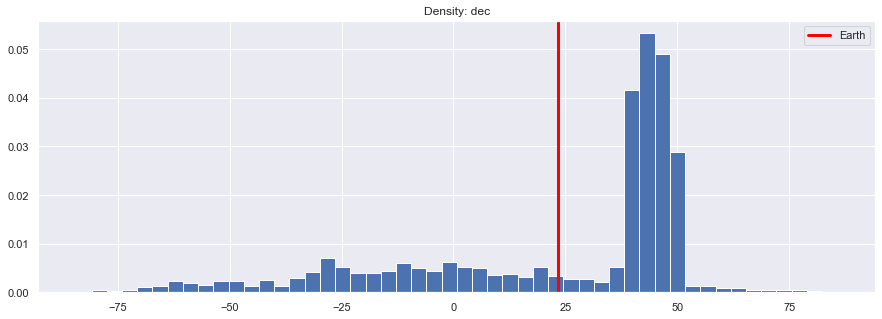

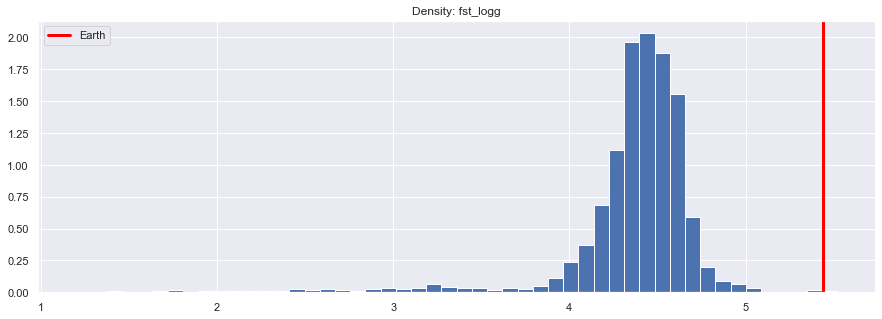

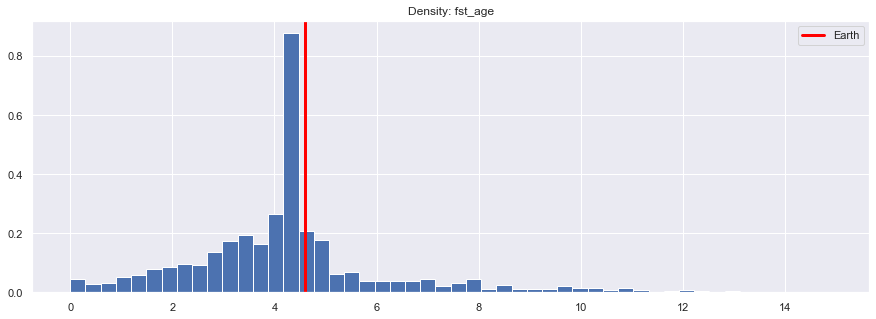

In [15]:
def displayDensity(data, earth):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_title("Density: {}".format(data.name))
    ax.hist(data, density=True, bins=50)
    ax.axvline(earth, color="red", label="Earth", linewidth=3)
    plt.legend()
    plt.show()
    
int_dist = ["fpl_rade", "dec", "fst_logg", "fst_age"] # interesting columns
    
for col in int_dist:
    displayDensity(df_vis[col], df_vis.loc[0, col])

> `fpl_rade` (radius of the exoplanet) points to that there are two types of the planets -- the ones with radius pretty simillar to the Earth and the ones with radius around 12 EU (Earth Units).
`dec` (declination of the planetary system) is pretty common around 40 degrees. This parameter is considered only for "fun" since it is not supposed to affect livability of the planet in any aspect.
In the chart `fst_logg` there is visible that the Sun has greater gravity acceleration at the surface than the most of the other stars. The last chart showing `fst_age` (stellar age) confirmes that the Sun is pretty in the mean of all the stars.

### 2.3 Correlation of Variables

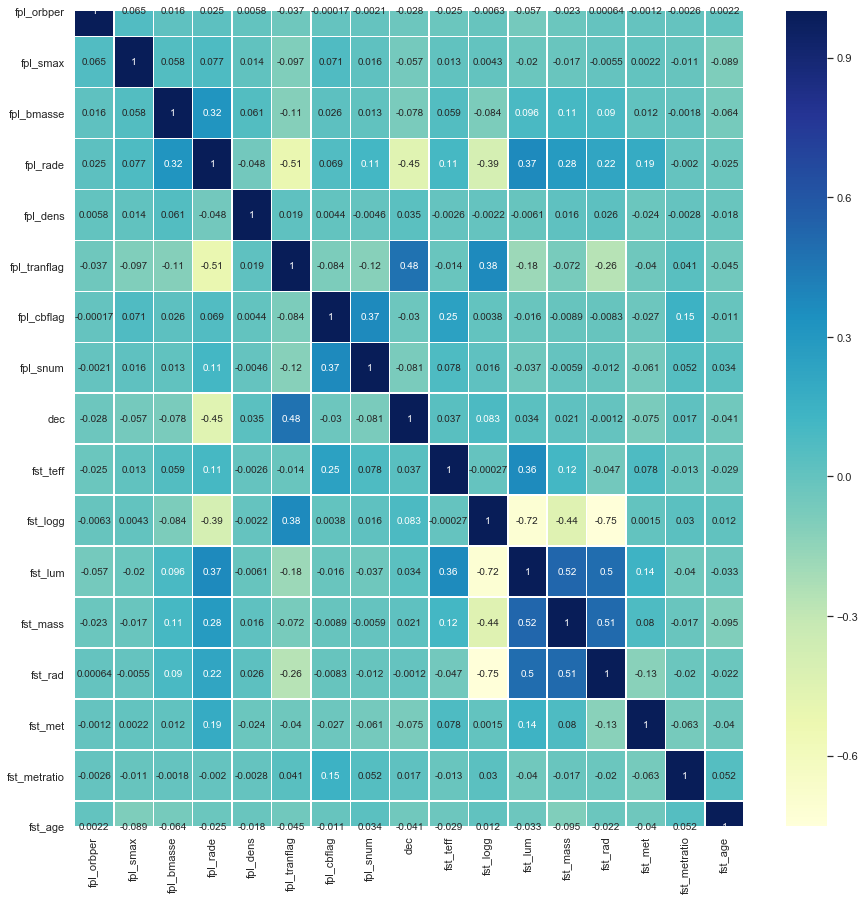

In [13]:
cor_matrix = df_vis.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor_matrix, annot=True, cmap="YlGnBu", linewidths=.5)

> The most of the variables are not correlated at all, but there are few pretty correlated:
* `fst_logg` and `fst_lum` ($-0.72$) = with gravity acceleration luminosity decreases,
* `fst_logg` and `fst_rad` ($-0.75$) = with gravity acceleration stellar radius decreases,
* `fst_lum` and `fst_mass` ($0.52$) = with luminosity stellar mass increases.

### 2.4 Joint Distribution of Highly Correlated Variables

Gravity acceleration (fst_logg) at the stellar surface and star luminosity (fst_lum).


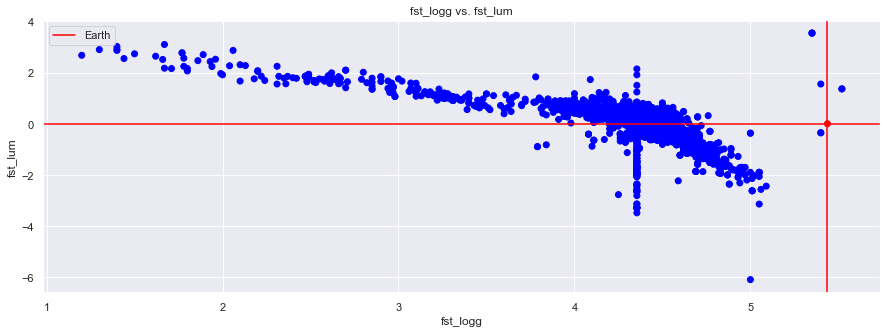

Gravity acceleration (fst_logg) at the stellar surface and the stellar radius (fst_rad).


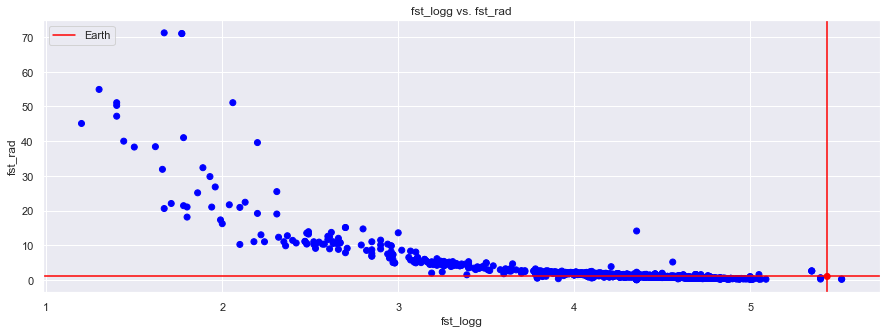

Stellar luminosity (fst_lum) and the stellar mass (fst_mass).


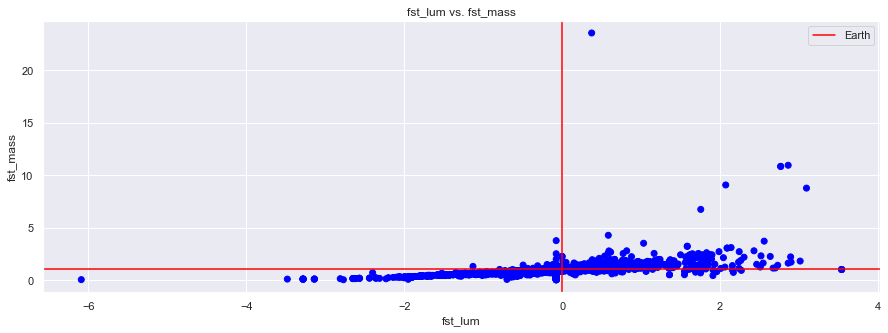

In [14]:
def displayJointDistribution(a, b):
    fig, ax = plt.subplots(figsize=(15,5))
    colors = ["blue"] * a.shape[0]
    colors[0] = "red"
    ax.axvline(a[0], color="red", label="Earth")
    ax.axhline(b[0], color="red")
    ax.scatter(a, b, c=colors)
    ax.set_title("{} vs. {}".format(a.name, b.name))
    ax.set_xlabel(a.name)
    ax.set_ylabel(b.name)
    plt.legend()
    plt.show()
    
print("Gravity acceleration (fst_logg) at the stellar surface and star luminosity (fst_lum).")
displayJointDistribution(df_vis["fst_logg"], df_vis["fst_lum"])
print("Gravity acceleration (fst_logg) at the stellar surface and the stellar radius (fst_rad).")
displayJointDistribution(df_vis["fst_logg"], df_vis["fst_rad"])
print("Stellar luminosity (fst_lum) and the stellar mass (fst_mass).")
displayJointDistribution(df_vis["fst_lum"], df_vis["fst_mass"])

> It's curious that stars with gravity acceleration at the surface $4.3^{10} \text{cm}/\text{s}^2$ have various luminosity  (from $-3.8^{10}\text{L}_\odot$ to $2.1^{10}\text{L}_\odot$)

## 3. Similarity Computation
> Computing similarity between earth and any other exoplanet

### 3.1 Normalization
> Some variables have greater deviation than others, therefore it is necessary to rescale all the values into range $\left[0,1\right]$

In [25]:
df_simil = df_vis.copy()
x = df_simil.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_simil = pd.DataFrame(x_scaled, columns=df_simil.columns)
df_simil.index.name = "rowid"

### 3.2 KMeans

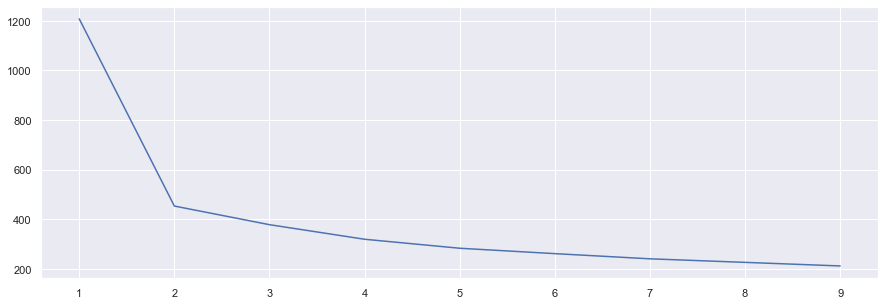

In [53]:
## finding the best number of clusters

n = []
score = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state = 1)
    kmeans.fit(df_simil)
    n.append(k)
    score.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(n, score)

## 4. Clustering
> Are the planets divided into some groups based on their parameters?